# THIS NOTEBOOK IS DEDICATED TO short GT and Sharp conditions


In [63]:
import os
import glob
import numpy as np
from platform import system as OS
import pandas as pd
import scipy.stats
import math
import datetime
from copy import deepcopy
from IPython.display import clear_output, display, HTML, Image
import matplotlib.cm as cm
import warnings
import types
warnings.filterwarnings("ignore")
import sys, time
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import mlab
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from pylab import *
import matplotlib.backends.backend_pdf
from sklearn.decomposition import KernelPCA

ThisNoteBookPath=os.path.dirname(os.path.realpath("__file__"))
CommonNoteBookesPath=os.path.join(os.path.split(ThisNoteBookPath)[0],"load_preprocess_rat")
CWD=os.getcwd()
os.chdir(CommonNoteBookesPath)
root='/data'
%run UtilityTools.ipynb
%run Animal_Tags.ipynb
%run Lesion_Size.ipynb
%run BatchRatBehavior.ipynb
%run plotRat_documentation_3_KinematicsInvestigation.ipynb
%run plotRat_documentation_1_GeneralBehavior.ipynb
%run loadRat_documentation.ipynb
%run RunBatchRat_3_CompareGroups.ipynb
os.chdir(CWD)

param={
    "binSize":0.25,
    "trialOffset":20., #max end of trial, in seconds (position will be cutted)
    "sigmaSmoothPosition":0.1,  #smooth the position
    #"sigmaSmoothPosition":0.33 for pavel dataType
    "sigmaSmoothSpeed":0.3, #smooth the speed
    "positionDiffRange": [2.,5.], #min and max differences allowed between two consecutive positions
                                  #min to correct start, max to correct jumps
    "pawFrequencyRange":[2.,10.],
    "startAnalysisParams":[10,0.2,0.5],
    "cameraToTreadmillDelay":2., #seconds, usual time between camera start and treadmill start
    "nbJumpMax" : 100., #if jumps>nbJumpMax, trial is badly tracked
    
    
    #parameter to detect end of trial (first position minima)
    "endTrial_backPos":55,  # minima is after the animal went once to the back (after first time position>backPos)
    "endTrial_frontPos":30, # minima's position is in front of treadmill (position[end]<frontPos)
    "endTrial_minTimeSec":4, # minima is after minTimeSec seconds (time[end]>minTimeSec)
    }
Y1,Y2=(0,90)
print('Done')

Done


In [64]:
class TwoTailPermTest:
    """
    Permutation test as to whether there is significant difference between group one and two.
    
    group1, group2: Represent the data. they could be either one dimentional (several realizations)
        or 2-D (several realizaions through out the time/space/... course)
        EX: x.shape==(15,500) means 15 trials/samples over 500 time bins

    nIterations: Number of iterations used to shuffle. max(iterN)=(len(x)+len(y))!/len(x)!len(y)!

    initGlobConfInterval:
        Initial value for the global confidence band.

    sigma: the standard deviation of the gaussian kernel used for smoothing when there are multiple data points,
        based on the Fujisawa 2008 paper, default value: 0.05

    Outputs:
        pVal: P-values
        highBand, lowBand: AKA boundary. Represents global bands.
        significantDiff: An array of True or False, indicating whether there is a difference.
    
    """  
    def __init__(self, group1, group2, nIterations=1000, initGlobConfInterval=5, smoothSigma=0.05):
        self.group1, self.group2 = group1, group2
        self.nIterations, self.smoothSigma = nIterations, smoothSigma
        self.initGlobConfInterval = initGlobConfInterval

        self.checkGroups()

        # origGroupDiff is also known as D0 in the definition of permutation test.
        self.origGroupDiff = self.computeGroupDiff(group1, group2)

        # Generate surrogate groups, compute difference of mean for each group, and put in a matrix.
        self.diffSurGroups = self.setDiffSurrGroups()

        # Set statistics
        self.pVal = self.setPVal()
        self.highBand, self.lowBand = self.setBands()
        self.significantDiff = self.setSignificantGroup()

    def checkGroups(self):
        # input check
        if not isinstance(self.group1, np.ndarray) or not isinstance(self.group2, np.ndarray):
            raise ValueError("In permutation test, \"group1\" and \"group2\" should be numpy arrays.")

        if self.group1.ndim > 2 or self.group2.ndim > 2:
            raise ValueError('In permutation test, the groups must be either vectors or matrices.')

        elif self.group1.ndim == 1 or self.group2.ndim == 1:
            self.group1 = np.reshape(self.group1, (len(self.group1), 1))
            self.group2 = np.reshape(self.group2, (len(self.group2), 1))

    def computeGroupDiff(self, group1, group2):
        meanDiff = np.nanmean(group1, axis=0) - np.nanmean(group2, axis=0)
        
        if len(self.group1[0]) == 1 and len(self.group2[0]) == 1:
            return [meanDiff]
        
        return smooth(meanDiff, sigma=self.smoothSigma, order=0, 
                    mode='constant', cval=0, truncate=4.0)

    def setDiffSurrGroups(self):
        # shuffling the data
        self.concatenatedData = np.concatenate((self.group1,  self.group2), axis=0)
        
        diffSurrGroups = np.zeros((self.nIterations, self.group1.shape[1]))
        for iteration in range(self.nIterations):
             # Generate surrogate groups
            surrGroup1, surrGroup2 = self.generateSurrGroup()
            
            # Compute the difference between mean of surrogate groups
            surrGroupDiff = self.computeSurrGroupDiff(surrGroup1, surrGroup2) 
            
            # Store individual differences in a matrix.
            diffSurrGroups[iteration, :] = surrGroupDiff

        return diffSurrGroups

    def generateSurrGroup(self):
        # Shuffle every column.
        np.random.shuffle(self.concatenatedData)  

         # Return surrogate groups of same size.            
        return self.concatenatedData[: self.group1.shape[0], :], self.concatenatedData[self.group1.shape[0]:, :]

    def computeSurrGroupDiff(self, surrGroup1, surrGroup2):
        return self.computeGroupDiff(surrGroup1, surrGroup2)
  
    def setPVal(self):
        positivePVals = np.sum(1*(self.diffSurGroups > self.origGroupDiff), axis=0) / self.nIterations
        negativePVals = np.sum(1*(self.diffSurGroups < self.origGroupDiff), axis=0) / self.nIterations
        return np.array([np.min([1, 2*pPos, 2*pNeg]) for pPos, pNeg in zip(positivePVals, negativePVals)])

    def setBands(self):
        if len(self.origGroupDiff) < 2:  # single point comparison
            return None, None
        
        alpha = 100 # Global alpha value
        highGlobCI = self.initGlobConfInterval  # global confidance interval
        lowGlobCI = self.initGlobConfInterval  # global confidance interval
        while alpha >= 5:
            highBand = np.percentile(a=self.diffSurGroups, q=100-highGlobCI, axis=0)
            lowBand = np.percentile(a=self.diffSurGroups, q=lowGlobCI, axis=0)
            
            breaksPositive = np.sum(
                [np.sum(self.diffSurGroups[i, :] > highBand) > 1 for i in range(self.nIterations)]) 
            
            breaksNegative = np.sum(
                [np.sum(self.diffSurGroups[i, :] < lowBand) > 1 for i in range(self.nIterations)])
            
            alpha = ((breaksPositive + breaksNegative) / self.nIterations) * 100
            highGlobCI = 0.95 * highGlobCI
            lowGlobCI = 0.95 * lowGlobCI
        return highBand, lowBand           

    def setSignificantGroup(self):
        if len(self.origGroupDiff) < 2:  # single point comparison
            return self.pVal <= 0.05

        # finding significant bins
        globalSig = np.logical_or(self.origGroupDiff > self.highBand, self.origGroupDiff < self.lowBand)
        pairwiseSig = np.logical_or(self.origGroupDiff > self.setPairwiseHighBand(), self.origGroupDiff < self.setPairwiseLowBand())
        
        significantGroup = globalSig.copy()
        lastIndex = 0
        for currentIndex in range(len(pairwiseSig)):
            if (globalSig[currentIndex] == True):
                lastIndex = self.setNeighborsToTrue(significantGroup, pairwiseSig, currentIndex, lastIndex)

        return significantGroup
    
    def setPairwiseHighBand(self):        
        return np.percentile(a=self.diffSurGroups, q=100 - self.initGlobConfInterval, axis=0)

    def setPairwiseLowBand(self):        
        return np.percentile(a=self.diffSurGroups, q=self.initGlobConfInterval, axis=0)


    def setNeighborsToTrue(self, significantGroup, pairwiseSig, currentIndex, previousIndex):
        """
            While the neighbors of a global point pass the local band (consecutively), set the global band to true.
            Returns the last index which was set to True.
        """ 
        if (currentIndex < previousIndex):
            return previousIndex
        
        for index in range(currentIndex, previousIndex, -1):
            if (pairwiseSig[index] == True):
                significantGroup[index] = True
            else:
                break

        previousIndex = currentIndex
        for index in range(currentIndex + 1, len(significantGroup)):
            previousIndex = index
            if (pairwiseSig[index] == True):
                significantGroup[index] = True
            else:
                break
        
        return previousIndex
    
    def plotSignificant(self,ax: plt.Axes.axes,y: float,x=None,**kwargs):
        if x is None:
            x=np.arange(0,len(self.significantDiff))+1
        for x0,x1,p in zip(x[:-1],x[1:],self.significantDiff):
            if p:
                ax.plot([x0,x1],[y,y],zorder=-2,**kwargs)
        

In [3]:
def plot_session_median_trajectory(data,ax, **kwargs):
    posDict=data.position
    maxL=np.nanmax(list(data.stopFrame.values()))
    maxL=int(maxL)
    position=np.ones((maxL,len(posDict.keys())))*np.nan
    time=np.arange(-data.cameraToTreadmillDelay,
                   (maxL-data.cameraSamplingRate)/data.cameraSamplingRate,
                   1/data.cameraSamplingRate)
    
    
    for i,trial in enumerate(posDict):
        pos=posDict[trial][:data.stopFrame[trial]]
        position[:len(pos),i]=pos
    
    #keeping data where 70% of points exist
    nanSum=np.sum(np.isnan(position),axis=1)
    try:
        maxTraj=np.where(nanSum>.3*position.shape[1])[0][0]
    except IndexError:
        maxTraj=position.shape[1]
    
    
    ax.plot(time[:maxTraj], np.nanmedian(position,axis=1)[:maxTraj], lw=.5, **kwargs)    

    ax.set_ylabel("Position (cm)")
    ax.set_xlabel("Time (s) relative to camera start")
    
    return position
    

def plot_median_trajectory(root, ax, profile, animalList, sessionIdx,colors):
    
    for i,animal in enumerate(animalList):
        session=batch_get_session_list(root, animalList=[animal], profile=profile)['Sessions'][sessionIdx]

        data=Data(root,session[:6],session,
                  param=param,redoPreprocess=False, saveAsPickle=False);
        data.position_correction()

        plot_session_median_trajectory(data,ax,color=colors[i],label=animal)

    ax.set_title(f'Session #{sessionIdx+1}',pad=0,fontsize='small')
    ax.set_ylim([Y1,Y2])
    ax.set_yticks([Y1,Y2/2,Y2])
    ax.set_yticklabels([Y1,'',Y2])
    ax.set_xlim([-1,8])
    ax.set_xticks([0,7])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds(0,7)
    ax.set_xlabel('Trial time (s)')
    ax.set_ylabel('Position (cm)')
    ax.spines['left'].set_bounds(Y1,Y2)
        
    return
def get_ordered_colors(colormap, n):
    colors = []
    cmap = plt.cm.get_cmap(colormap)
    for colorVal in np.linspace(0, 1, n):
        colors.append(cmap(colorVal))
    return colors

In [38]:
profileC={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':['10'],
         'Speed':'10',
         'Tag':['Control']
         }
animalListC=batch_get_animal_list(root,profile)
print(animalList)



['Rat077', 'Rat078', 'Rat084', 'Rat085', 'Rat088', 'Rat091', 'Rat095', 'Rat096', 'Rat098', 'Rat103', 'Rat104', 'Rat110', 'Rat113', 'Rat120', 'Rat137', 'Rat138', 'Rat139', 'Rat140', 'Rat149', 'Rat150', 'Rat151', 'Rat152', 'Rat161', 'Rat162', 'Rat163', 'Rat164', 'Rat165', 'Rat166', 'Rat215', 'Rat216', 'Rat217', 'Rat218', 'Rat219', 'Rat220', 'Rat221', 'Rat222', 'Rat223', 'Rat224', 'Rat225', 'Rat226', 'Rat227', 'Rat228', 'Rat229', 'Rat230', 'Rat231', 'Rat232', 'Rat246', 'Rat247', 'Rat248', 'Rat249', 'Rat250', 'Rat251', 'Rat252', 'Rat253', 'Rat254', 'Rat255', 'Rat256', 'Rat257', 'Rat258', 'Rat259', 'Rat260', 'Rat261', 'Rat262', 'Rat263', 'Rat264', 'Rat265', 'Rat297', 'Rat298', 'Rat299', 'Rat300', 'Rat305', 'Rat306', 'Rat307', 'Rat308']


In [39]:
profile={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':['10'],
         'Speed':'10',
         'Tag':['ShortGT']
         }
# animalList=batch_get_animal_list(root,profile)
print(animalList)

['Rat077', 'Rat078', 'Rat084', 'Rat085', 'Rat088', 'Rat091', 'Rat095', 'Rat096', 'Rat098', 'Rat103', 'Rat104', 'Rat110', 'Rat113', 'Rat120', 'Rat137', 'Rat138', 'Rat139', 'Rat140', 'Rat149', 'Rat150', 'Rat151', 'Rat152', 'Rat161', 'Rat162', 'Rat163', 'Rat164', 'Rat165', 'Rat166', 'Rat215', 'Rat216', 'Rat217', 'Rat218', 'Rat219', 'Rat220', 'Rat221', 'Rat222', 'Rat223', 'Rat224', 'Rat225', 'Rat226', 'Rat227', 'Rat228', 'Rat229', 'Rat230', 'Rat231', 'Rat232', 'Rat246', 'Rat247', 'Rat248', 'Rat249', 'Rat250', 'Rat251', 'Rat252', 'Rat253', 'Rat254', 'Rat255', 'Rat256', 'Rat257', 'Rat258', 'Rat259', 'Rat260', 'Rat261', 'Rat262', 'Rat263', 'Rat264', 'Rat265', 'Rat297', 'Rat298', 'Rat299', 'Rat300', 'Rat305', 'Rat306', 'Rat307', 'Rat308']


In [40]:
animalList=['Rat280', 'Rat281', 'Rat282', 'Rat291', 'Rat342', 'Rat346', 'Rat350']
PERF=['standard deviation of entrance time','mean entrance time (sec)']

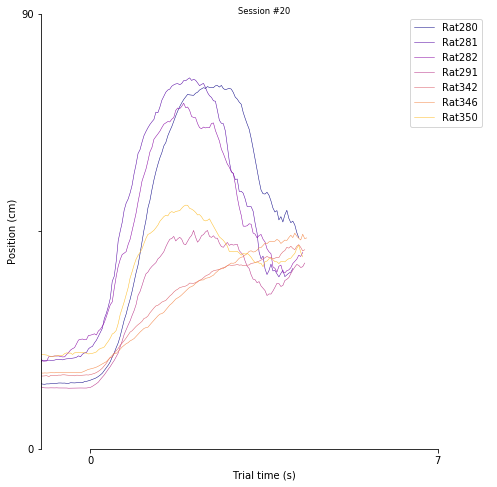

In [41]:
sessionIdx=19
colors=get_ordered_colors(colormap='plasma', n=len(animalList)+1)[:-1]

plt.close('all')
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)



plot_median_trajectory(root,ax, profile, animalList, sessionIdx,colors)
ax.legend()

In [87]:
data={}
for animal in animalList:
    a=data_fetch(root,animal,profile,PERF, NbSession=slice(15,None))
    a=list(a.values())
    data[animal]=[a[0][i]/a[1][i] for i,_ in enumerate(a[0])]

In [88]:
data

{'Rat280': [0.2907451953025107,
  0.24876825165742644,
  0.3729791639253789,
  0.2090593171077375,
  0.28538817478823314],
 'Rat281': [0.30156840731097906,
  0.26898988911953403,
  0.27340481724316484,
  0.285373994130452,
  0.2830816559956511],
 'Rat282': [0.483795891174407,
  0.4070185625796459,
  0.3834857019023161,
  0.38996046309918064,
  0.37221325790661886],
 'Rat291': [0.36119403514299575,
  0.30019804870723005,
  0.305784375114624,
  0.27677175136258503,
  0.3368633828019691],
 'Rat342': [0.45200815616513357,
  0.4094159819685475,
  0.4716901375234153,
  0.5380088240336075,
  0.3177742889438476,
  0.2983454153322295,
  0.5290801596105817],
 'Rat346': [0.4938636779474768,
  0.36325687261105766,
  0.4871402520290202,
  0.58164926230887,
  0.36868352685287903,
  0.3136933419525059,
  0.37815910806496533],
 'Rat350': [0.40403985529037034,
  0.40328115488129196,
  0.5103986002283053,
  0.4444559450435144,
  0.3880922503306207,
  0.30178267354479477,
  0.34599168386440765]}

In [44]:
dataC={}
for animal in animalListC:
    a=data_fetch(root,animal,profileC,PERF, NbSession=-1)
    a=list(a.values())
    dataC[animal]=a[0][0]/a[1][0]

In [ ]:
dataC

In [46]:
data=np.array(list(data.values()))
dataC=np.array(list(dataC.values()))

In [48]:
pTest=TwoTailPermTest(group1=data, group2=dataC, nIterations=1000)

In [49]:
pTest.pVal,pTest.significantDiff

(array([0.008]), array([ True]))

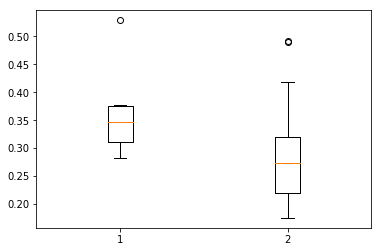

In [51]:
plt.boxplot([data,dataC]);

# **effect of HiPenalty Condition**

In [38]:
def plot_goal_time_change(root, Profiles, N, GT, badAnimals, TaskParamToPlot, wspace, gs, fig):
    """
    gs could be either gridSpec or a list of axes with 
    """
    if isinstance(gs,matplotlib.gridspec.SubplotSpec):
        gssub = gs.subgridspec(1, len(Profiles)-1,wspace=wspace)
        axes=[]
    else:
        gssub=False
        axes=gs
    for eventN in range(len(N)-1):
        #getting the data
        _,SessionDict=event_detect(root, Profiles[eventN], Profiles[eventN+1], badAnimals=badAnimals)

        Results,nSessionPre,nSessionPost=event_statistic(root,
                                                         SessionDict,
                                                         parameter=param,
                                                         redo=False,
                                                         TaskParamToPlot=[TaskParamToPlot])
        
        assert N[eventN]<nSessionPre and N[eventN+1]<nSessionPost,\
               f"fewer sessions available than requested:{Profiles[eventN]['Tag']}"

        data=np.array(list(Results[TaskParamToPlot].values()))
        data=data[:,
                  nSessionPre-N[eventN] : nSessionPre+N[eventN+1]
                 ]

        y=np.nanpercentile(data,50,axis=0)
        yerr=np.nanpercentile(data,(25,75),axis=0)

        #getting the axes
        if gssub:
            ax=fig.add_subplot(gssub[0, eventN])
        else:
            ax=axes[eventN]

        #plotting
        xLabel=list(range(-N[eventN],N[eventN+1]+1))
        xLabel.remove(0)
        ax.errorbar(xLabel,y,yerr=abs(yerr-y), ecolor='k', fmt='k-o',
                    markersize=2, elinewidth=1, linewidth=1, markerfacecolor='w',zorder=1)
        ax.plot([xLabel[0],-1,1,xLabel[-1]],[GT[eventN],GT[eventN],GT[eventN+1],GT[eventN+1]],
                'm--',lw=1, zorder=-5)



        if xLabel[0]<=-10 or xLabel[-1]>=10:
            newLabel=[label for label in xLabel if label%10==0]
#             newLabel.extend([1,-1])
#             newLabel.extend([xLabel[0],xLabel[-1]])
            newLabel=list(set(newLabel))
            newLabel.sort()

        ax.set_xlim([xLabel[0]-1,xLabel[-1]+1])
        ax.set_xticks(newLabel)
#         ax.spines['bottom'].set_bounds(xLabel[0],xLabel[-1])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.set_ylabel(TaskParamToPlot)
        ax.set_ylim([2,5])
        ax.set_yticks(list(set(GT)))
        ax.vlines(x=0, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1]*.9, color='k',linestyles='--',lw=.8)

        if gssub:
            axes.append(ax)

    axes[1].set_xlabel('Session relative to goal time change')
    axes[0].spines['left'].set_position(('axes',-.05))
    for ax in axes[1:]:
        ax.yaxis.set_visible(False)
        ax.spines['left'].set_visible(False)

    return tuple(axes)

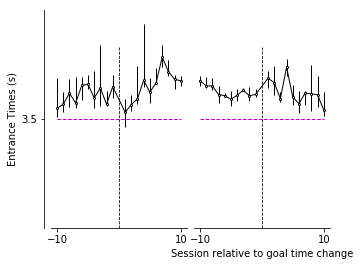

In [41]:
if "__file__" not in dir():

    profile1={'Type':'Good',
              'rewardType':'Progressive',
              'initialSpeed':'10',
              'Speed':'10',
              'Tag':['ShortGT']
              }
    profile2={'Type':'Good',
              'rewardType':'Progressive',
              'initialSpeed':'10',
              'Speed':'10',
              'Tag':['ShortGT-Late-HiPenalty','ShortGT-Late-HiPenalty25']
              }
    profile3={'Type':'Good',
              'rewardType':'Progressive',
              'initialSpeed':'10',
              'Speed':'10',
              'Tag':['ShortGT-Late-Sharp']
              }

    #number of sessions to plot
    N=[10,10,10]
    #goal times
    GT=[3.5,3.5,3.5]
    badAnimals=['RatBAD']
    TaskParamToPlot="percentile entrance time"
    wspace=0.05
    
    
    Profiles=(profile1,profile2,profile3,)
    plt.close('all')
    fig=plt.figure(figsize=(5,4))
    gs=fig.add_gridspec(1,1)[0]
    
    axes=plot_goal_time_change(root, Profiles, N, GT, badAnimals, TaskParamToPlot, wspace, gs, fig)
#     axes=plot_goal_time_change(root, Profiles, N, GT, badAnimals,
#                                TaskParamToPlot='standard deviation of entrance time', wspace=wspace, gs=axes, fig=fig)
    
    axes[0].set_ylabel('Entrance Times (s)')

In [4]:
profile={'Type':'Good',
     'rewardType':'Progressive',
     'initialSpeed':'10',
     'Speed':'10',
     'Tag':['ShortGT',]
              }
animalList=batch_get_animal_list(root,profile)
print(animalList)

['Rat280', 'Rat281', 'Rat282', 'Rat291', 'Rat342', 'Rat346', 'Rat350']


# Max position

In [69]:
def get_positions_array_Bad_StereotypedTrials(data,onlyBad=True):
    posDict=data.position
    #number of frames to keep 
    cs=data.cameraSamplingRate
    size=np.max(data.maxTrialDuration)*cs#int(abs(minTime*cs))
    #put all positions in a 2D array
    allTraj=[]
    for trial in posDict:
        if onlyBad and (trial in data.goodTrials):
            continue
        if data.entranceTime[trial] == data.maxTrialDuration[trial]:
            continue
        #index where the steretyped trajectory ends
        endIndex0=data.indexEndTrial[trial]
        endIndex1=(data.entranceTime[trial]+data.cameraToTreadmillDelay)*cs
        startIndex=data.startFrame[trial]
        if isNone(endIndex0):
            if isNone(endIndex1):
                continue
            elif endIndex1<startIndex:
                continue
            endIndex=int(endIndex1)
        elif isNone(endIndex1):
            endIndex=endIndex0
        else:
            endIndex=min([endIndex0,int(endIndex1)])
        
        pos=posDict[trial][startIndex:endIndex]
       
        allTraj.append(pos)

    allTraj=np.asarray(allTraj)
    return allTraj

def max_pos_trials(data, initialPos=24):
    data.position_correction()
    detect_trial_end(data)
    allTraj=get_positions_array_end_StereotypedTrials(data,onlyGood=True)
    badTraj=get_positions_array_Bad_StereotypedTrials(data,onlyBad=True)
    maxPos=[]
    badPos=[]
    try:
        for traj in allTraj:
            if traj[~np.isnan(traj)][0] < initialPos:
                maxPos.append(np.nanmax(traj))


        for traj in badTraj:
            if traj[~np.isnan(traj)][0] < initialPos:
                badPos.append(np.nanmax(traj))
    except IndexError:
        # due to lack of any non-nan point
        logging.error(f'error in trial position processing of {data.sessionPath}')
        
    return np.array(maxPos),np.array(badPos)

def prob_max_pos_for_correct(animalList, profile, SessionRange, trdBins):

    param=[max_pos_trials]

    rd=[]
    for animal in animalList:
        data=data_fetch(root,animal,profile, param, NbSession=SessionRange[1]+1)
        rd.append(data[param[0].__name__][SessionRange[0]:SessionRange[-1]])
    
    GData=dict.fromkeys(animalList,None)
    BData=dict.fromkeys(animalList,None)
    for i,animal in enumerate(animalList):
        GData[animal]=[]
        BData[animal]=[]
        for j in range(len(rd[i])):
            GData[animal].extend(rd[i][j][0])
            BData[animal].extend(rd[i][j][1])

    
    distanceB=[]
    distanceG=[]
    for col,animal in enumerate(animalList):
        distanceG.extend(GData[animal])
        distanceB.extend(BData[animal])
        
    distanceG=np.array(distanceG)
    distanceB=np.array(distanceB)
    PtotalG,_= np.histogram(a=distanceG,bins=trdBins,density=True)
    PtotalB,_= np.histogram(a=distanceB,bins=trdBins,density=True)
    
    return PtotalG, PtotalB


def plot_prob_max_pos(ax, animalList, profile, SessionRange, trdBins):
    
    PtotalG, PtotalB=prob_max_pos_for_correct(animalList,
                                             profile,
                                             SessionRange,
                                             trdBins)
    
    binSize=trdBins[1]-trdBins[0]    

    Gbar=ax.bar(x=trdBins[:-1], height=PtotalG,
                width=binSize, align='edge',
                edgecolor='None',color='lime',   alpha=.6, zorder=0, label='Correct trials')
    Bbar=ax.bar(x=trdBins[:-1], height=PtotalB,
                width=binSize, align='edge',
                edgecolor='None',color='tomato', alpha=.6, zorder=0, label='Error trials')

    y0,y1=ax.get_ylim()
    ax.set_xlabel('Max position (cm)')
    ax.set_ylabel('Probability')
    ax.set_ylim((y0-y1)/100,y1)
    ax.set_xlim([trdBins[0]-trdBins.step,trdBins[-1]+trdBins.step])
    ax.set_xticks([Y1,Y2/2,Y2])
    ax.set_xticklabels([Y1,'',Y2])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds(Y1,Y2)
    ax.spines['left'].set_bounds(0,y1)
        
    return PtotalG, PtotalB

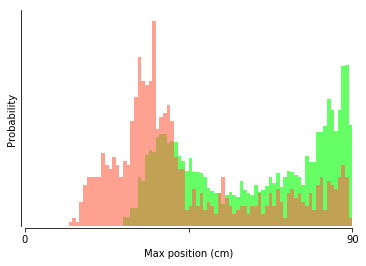

In [70]:
if "__file__" not in dir():
    profile={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'10',
             'Speed':['10'],
             'Tag':'ShortGT'
                  }
    animalList=['Rat280', 'Rat281', 'Rat282', 'Rat291', 'Rat342', 'Rat346', 'Rat350']

    Y1,Y2=[0,90]
    SessionRange=[15,30]
    trdBins=range(Y1,Y2+1,1)
    
    plt.close('all')
    ax=plt.gca()
    a=plot_prob_max_pos(ax, animalList, profile, SessionRange, trdBins)
    plt.show()
    

# code from \_exp4 notebook

### plotting correct trajectories aligned on detector crossing

In [ ]:
profile={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':['0'],
         'Speed':'0',
         'Tag':['ImmobileTreadmill']
         }
animalList=batch_get_animal_list(root,profile)
print(animalList)

NbSession=5
Win=2

treadmillRange=[10,90]

In [ ]:
# def positions(data):
#     """
#     return good trajectories
#     """
#     posDict=data.position
#     time=data.rawTime #align on camera
#     pos=[]
#     for trial in posDict:
#         if trial not in data.goodTrials:
#             continue
#         pos.append(posDict[trial])
#     return pos

def posAlignEnd(data):
    """
    return good trajectories
    """
    posDict=data.position
    time=data.rawTime #align on camera
    pos=[]
    for trial in posDict:
        if trial not in data.goodTrials:
            continue
        et=data.entranceTime[trial]
        fs=data.cameraSamplingRate
        delay=data.cameraToTreadmillDelay
        assert et>=7,"Fuck!!!"
        th=int((et+delay)*fs)
        pos.append(posDict[trial][th-int(Win*fs):th])
    return pos

pos={}
for animal in animalList:
    data=data_fetch(root,animal,profile,[posAlignEnd], NbSession=NbSession)
    pos[animal]=[position for session in data[posAlignEnd.__name__] for position in session]

In [ ]:
axes=plt.subplots(len(animalList),1,figsize=(10,50))

for i,animal in enumerate(animalList):
    data=np.array(pos[animal]).T
    t=np.linspace(-Win,0,data.shape[0])
    axes[1][i].plot(t,data,color='k',linewidth=1,alpha=.5)
    histT0,bins0=np.histogram(data[0,:],20,range=(treadmillRange[0],treadmillRange[1]), density=True)
    histT1,bins1=np.histogram(data[-1,:],20,range=(treadmillRange[0],treadmillRange[1]), density=True)
    axes[1][i].barh(bins0[:-1],histT0*5,height=np.diff(bins0)[0],align='edge',left=-Win,color='g')
    axes[1][i].barh(bins1[:-1],-histT1*5,height=np.diff(bins1)[0],align='edge',left=0,color='r')
    
    axes[1][i].set_xlim([-Win,0])
    axes[1][i].set_title(animal)
    Nticks=len(axes[1][i].get_xticks())
    axes[1][i].set_xticklabels(np.linspace(-Win,0,Nticks))
    axes[1][i].set_ylabel('Position(cm)')

#     axes[1][i].spines['left'].set_position(('data',-.5))
#     axes[1][i].spines['right'].set_position(('data',Win+.5))

axes[1][i].set_xlabel('Time to cross the photodetector (s)');

## distribution of entrance times

In [ ]:
profile={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':['0'],
         'Speed':'0',
         'Tag':['ImmobileTreadmill']
         }
animalList=batch_get_animal_list(root,profile)
print(animalList)

NbSession=10

Bins=range(0,62,1)

In [ ]:
def entrance_time(data):
    """
    """
    return data.entranceTime

ET0={} #naive
ET1={} #trained

param=[entrance_time]
for animal in animalList:
    data=data_fetch(root,animal,profile, param, NbSession=abs(NbSession))
    ET0[animal]=[time for session in data[param[0].__name__] for time in session]
    
    data=data_fetch(root,animal,profile, param, NbSession=-abs(NbSession))
    ET1[animal]=[time for session in data[param[0].__name__] for time in session]

In [ ]:
axes=plt.subplots(len(animalList),2,figsize=(15,30))
globalMaxP=0

for i,animal in enumerate(animalList):
    hist0,bins0= np.histogram(ET0[animal], bins=Bins, density=True)
    hist1,bins1= np.histogram(ET1[animal], bins=Bins, density=True)
    globalMaxP=max([globalMaxP,*hist0,*hist1])
    
    axes[1][i][0].bar(x=bins0[:-1], height=hist0, width=1, align='edge')
    axes[1][i][1].bar(x=bins1[:-1], height=hist1, width=1, align='edge')

for i,animal in enumerate(animalList):
    axes[1][i][0].set_xlim([0,20])
    axes[1][i][1].set_xlim([0,20])
    
    axes[1][i][0].set_ylim([0,globalMaxP])
    axes[1][i][1].set_ylim([0,globalMaxP])
    
    axes[1][i][0].axvline(7,0,.5, color='m',linewidth=3)
    axes[1][i][1].axvline(7,0,.5, color='m',linewidth=3)
    
    axes[1][i][0].set_title('naive')
    axes[1][i][1].set_title('trained')
    
    axes[1][i][0].set_xlabel(param[0].__name__)
    axes[1][i][1].set_xlabel(param[0].__name__)
    
    axes[1][i][0].set_ylabel(f'Probability {animal}')
    axes[1][i][1].set_ylabel('Probability')

# run distance

In [ ]:
profile={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':['0'],
         'Speed':'0',
         'Tag':['ImmobileTreadmill']
         }
animalList=batch_get_animal_list(root,profile)
animalList=['Rat121', 'Rat122', 'Rat123', 'Rat124', 'Rat131', 'Rat132']
print(animalList)

def entrance_time(data):
    """
    """
    data.entranceTime[data.entranceTime==data.maxTrialDuration]=0
    return data.entranceTime

def run_distance(data):
    allTraj=get_positions_array_beginning(data,onlyGood=False,raw=False)
    et=(data.entranceTime+data.cameraToTreadmillDelay)*data.cameraSamplingRate
    for i,_ in enumerate(data.trials):
        if np.isnan(et[i]):
            th=(data.maxTrialDuration[i]+data.cameraToTreadmillDelay)*data.cameraSamplingRate
            th=int(th)
        else:
            th=int(et[i])
        allTraj[i,th-1:]=np.nan
    treadmillStep=np.expand_dims(data.treadmillSpeed[data.trials]/data.cameraSamplingRate,1)
    dis=np.nansum(np.absolute(np.diff(allTraj,axis=1)-treadmillStep),axis=1)
    return dis

param=[run_distance2,entrance_time]

NbSession=-10
GT=7
distBins=np.arange(0,160, 10)

print(distBins)

In [ ]:
et=[]
rd=[]
for animal in animalList:
    data=data_fetch(root,animal,profile, param, NbSession=NbSession)
    et.append(data[param[1].__name__])
    rd.append(data[param[0].__name__])
    
    
corrData=dict.fromkeys(animalList,None)
distData=dict.fromkeys(animalList,None)
for i,animal in enumerate(animalList):
    corrData[animal]=[]
    distData[animal]=[]
    for j in range(abs(NbSession)):
        if len(et[i][j])==len(rd[i][j]):
            corrData[animal].extend(et[i][j]>GT)
            distData[animal].extend(rd[i][j])

Panimal=np.ones((len(distBins)-1,len(animalList)))*np.nan
animalOrder=[]
for col,animal in enumerate(animalList):
    animalOrder.append(animal)
    correct =np.array(corrData[animal])
    distance=np.array(distData[animal])
    for i,(loBin,hiBin) in enumerate(zip(distBins[:-1],distBins[1:])):
        signal=correct[np.logical_and(distance>=loBin,distance<hiBin)]
        if len(signal)> 10:
            Panimal[i,col]= sum(signal)/len(signal)

Ptotal=np.ones((len(distBins)-1,len(animalList)))*np.nan
correct=[]
distance=[]
for col,animal in enumerate(animalList):
    correct.extend(corrData[animal])
    distance.extend(distData[animal])
correct=np.array(correct)
distance=np.array(distance)
for i,(loBin,hiBin) in enumerate(zip(distBins[:-1],distBins[1:])):
    signal=correct[np.logical_and(distance>=loBin,distance<hiBin)]
    if len(signal)> 10:
        Ptotal[i,col]= sum(signal)/len(signal)

        
        

In [ ]:
plt.plot(distBins[:-1],Panimal[:,:],'-*');
plt.ylim([-.05,1.05])
plt.title('$P(correct | distance)$')
plt.xlabel('Run Distance')

In [ ]:
plt.plot(distBins[:-1],Ptotal[:,:],'-*');
plt.ylim([-.05,1.05])
plt.title('$P(correct | distance)$')
plt.xlabel('Run Distance')

In [ ]:
ET0={} #naive
ET1={} #trained
RD0={}
RD1={}

param=["Run Distance","% good trials"]
for animal in animalList:
    data=data_fetch(root,animal,profile, param, NbSession=abs(NbSession))
    ET0[animal]=data[param[0]]
    RD0[animal]=data[param[1]]
    
    data=data_fetch(root,animal,profile, param, NbSession=-abs(NbSession))
    ET1[animal]=data[param[0]]
    RD1[animal]=data[param[1]]
    
ET0=np.array(list(ET0.values()))
ET1=np.array(list(ET1.values()))
RD0=np.array(list(RD0.values()))
RD1=np.array(list(RD1.values()))

In [ ]:
plt.plot(ET1.flatten(),RD1.flatten(),'*')
plt.xlabel(param[0])
plt.ylabel(param[1])
plt.title(f'p-val={scipy.stats.pearsonr(ET1.flatten(),RD1.flatten())[1]}')

In [ ]:
scipy.stats.pearsonr(ET1.flatten(),RD1.flatten())